# GPU vs CPU benchmark
### single-layer Earth atmosphere, $H_2 O$
### Using HITRAN, `jax`, and NVIDIA GPUs


In [1]:
%%capture
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

In [2]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [3]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [4]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [5]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [6]:
@jit
def transmission_of_T_p(T, p, nus, vol_mix_ratio=0.001, path_length_km=3.0):
    '''Return the absorption coefficient as a function of T'''
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,0.001, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    
    tau = abs_coeff * (vol_mix_ratio*2.688392857142857e+19) * (path_length_km*100000.0)
    return np.exp(-tau)

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [7]:
import time

In [8]:
n_air = hapi.getColumn('H2O', 'n_air')
gamma_air = hapi.getColumn('H2O', 'gamma_air')
gamma_self = hapi.getColumn('H2O', 'gamma_self')
E_lower = hapi.getColumn('H2O', 'elower')
g_lower = hapi.getColumn('H2O', 'gpp')
g_upper = hapi.getColumn('H2O', 'gp')
nu_lines = hapi.getColumn('H2O', 'nu')
delta_air = hapi.getColumn('H2O', 'delta_air')
S_ij_296 = hapi.getColumn('H2O', 'sw')

In [9]:
#wls = (np.linspace(15000, 25000, 100000) * u.Angstrom)[::-1]
#nus = np.array(wls.to(1/u.cm, equivalencies=u.spectral()).value)
#wls = wls.value

In [10]:
import pandas as pd

In [11]:
time_arr = []
nn = np.array([10_000, 100_000, 1_000_000, 10_000_000])
for n_samples in nn:
    t0 = time.time()
    nus = np.linspace(4000, 6666.66666666, n_samples)
    transmission_of_T_p(291.0, 0.89, nus)
    time_arr.append(time.time() - t0)

In [12]:
tt = np.array(time_arr)

In [13]:
df_cpu = pd.read_csv('../data/CPU_benchmark_single_layer.csv')
df_gpu_plat = pd.read_csv('../data/GPU_benchmark_single_layer_platform.csv')
df_gpu_def = pd.read_csv('../data/GPU_benchmark_single_layer_default.csv')

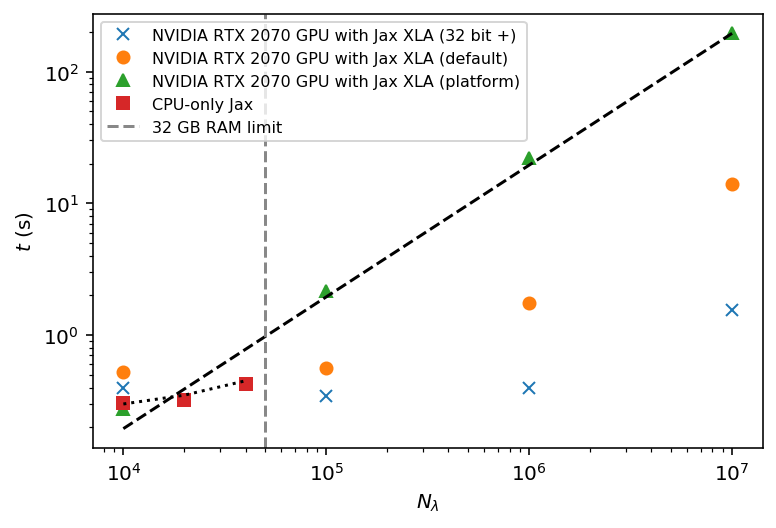

In [15]:
plt.plot(nn, tt, 'x', label='NVIDIA RTX 2070 GPU with Jax XLA (32 bit +)');
plt.plot(df_gpu_def.nn, df_gpu_def.tt, 'o', label='NVIDIA RTX 2070 GPU with Jax XLA (default)'); 
plt.plot(df_gpu_plat.nn, df_gpu_plat.tt, '^', label='NVIDIA RTX 2070 GPU with Jax XLA (platform)');
plt.plot(df_cpu.nn, df_cpu.tt, 's', label='CPU-only Jax'); 
plt.yscale('log'); plt.xscale('log'); plt.xlabel('$N_\lambda$') ; plt.ylabel('$t$ (s)');
plt.plot(df_gpu_plat.nn, 1.95e-5 * df_gpu_plat.nn, 'k--')
plt.plot(df_cpu.nn, 0.25+0.000005 * df_cpu.nn, 'k:');
plt.axvline(50000, linestyle='dashed', color='#888888', label='32 GB RAM limit');
plt.legend(loc='upper left', fontsize=8);

In [15]:
#pd.DataFrame({'nn':nn, 'tt':tt}).to_csv('../data/GPU_benchmark_single_layer_default.csv')

Awesome!  Ok, I think this figure makes sense.  The CPU is faster (shallower slope) than the CPU, but runs out of memory sooner.  The GPU can support streaming multiprocessors so it trades computation time for memory.

The strange thing is that the wall-clock time is the same for either Jax-based or platform memory allocation, but somehow the Python `time` function concludes different times.  I'm perplexed!  I think the best thing to do is use the `default` XLA memory allocation.


Most importantly, the 32-bit Jax is much-much faster than the 64-bit, which makes sense.